In [1]:
# Import models and modules
import cv2
import random, sys
import numpy as np
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation
from keras.layers import Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras import models
import keras.callbacks
from PIL import Image, ImageDraw 
import tensorflow as tf
import os
import time
import sys

/opt/conda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def data_process(namelist,p,num):
    Input_vehicles = []
    Output_labels = []
    assert isinstance(namelist,list)
    for i in range(len(namelist)):
        path = p + namelist[i]
        files= os.listdir(path)
        number = 0
        for file in files:
            if number == num:
                break
            number += 1
            if file != "Thumbs.db" and file !=".DS_Store" and file !='.ipynb_checkpoints':              
                im = Image.open(path+"/"+file);
                im_resized = im.resize((256,256),Image.ANTIALIAS)
                im_resized = im_resized.convert()
                data = im_resized.getdata()
                data = np.array(data)
                label = i
                if data.ndim == 2: # delete invalued images 
                    Input_vehicles.append(data)
                    Output_labels.append(label)
    return Input_vehicles, Output_labels

In [3]:
# imput data, unify size, change to array
namelist_vehicle = ['Electric','Motor home','Passenger van','Pickup Truck','School Bus','Sedan','Shuttle bus','Sport Car','Stock Car','SUV']
#namelist_vehicle = namelist_vehicle[:1]
path1 = 'Test/'
Input_vehicles, Output_labels = data_process(namelist_vehicle,path1,5)
Input_vehicles = np.array(Input_vehicles)
Output_labels = np.array(Output_labels)
Input_vehicles = Input_vehicles.reshape([-1,256,256,3])
print(Input_vehicles.shape)

(50, 256, 256, 3)


In [4]:
# data enhancement

# get images
def get_every_image(data, i):
    im = data[i:i+1]
    im = im[0]
    return im

# moving
def moving(im, a, size, path, class_name ,num):  
        img1 = im  
        img2 = im 
        img3 = im 
        img4 = im 
        num = str(num)
        cv2.imwrite(path + class_name + '/' + num + 'origin.png', im)
        
        img1 = np.concatenate((img1[:, a:], img1[:, :a]), axis=1)    
        cv2.imwrite(path + class_name + '/' + num + 'mov_left.png', img1)  
        img2 = np.concatenate((img2[:, size[1] - a:], img2[:, :size[1] - a]), axis=1)  # 右  
        cv2.imwrite(path + class_name + '/' + num +  'mov_right.png', img2)  
        img3 = np.concatenate((img3[a:, :], img3[:a, :]), axis=0)    
        cv2.imwrite(path + class_name + '/' + num +  'mov_up.png', img3)  
        img4 = np.concatenate((img4[size[0] - a:, :], img4[:size[0] -a, :]), axis=0)   #下  
        cv2.imwrite(path + class_name + '/' + num +  'mov_down.png', img4)  

path = 'Test/Data_enhancement/'
number = Input_vehicles.shape[0]/10
for i in range(len(namelist_vehicle)):
    for j in range(number):
        im = get_every_image(Input_vehicles, j+i*number)
        moving(im, 10, (256,256), path, class_name = namelist_vehicle[i] , num = j)
    

In [5]:
# reload data
namelist_vehicle = ['Electric','Motor home','Passenger van','Pickup Truck','School Bus','Sedan','Shuttle bus','Sport Car','Stock Car','SUV']

path2 = 'Test/Data_enhancement/'
Input_vehicles, Output_labels = data_process(namelist_vehicle,path2,30)
Input_vehicles = np.array(Input_vehicles)
Output_labels = np.array(Output_labels)
Input_vehicles = Input_vehicles.reshape([-1,256,256,3])
print(Input_vehicles.shape)
print(Output_labels)

(250, 256, 256, 3)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]


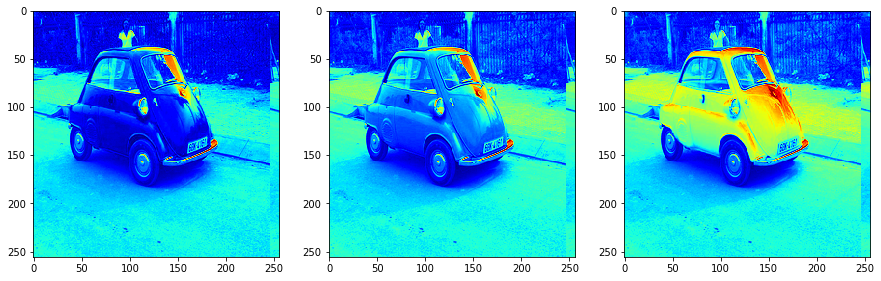

In [6]:
# Show Picture example
sample = Input_vehicles[0].transpose([2,0,1])
sample_red = sample[0]
sample_green = sample[1]
sample_blue = sample[2]

plt.figure(1,figsize = (5*3,5*1))
plt.set_cmap('jet')
plt.subplot(1,3,1)
plt.imshow(sample_red)
plt.subplot(1,3,2)
plt.imshow(sample_green)
plt.subplot(1,3,3)
plt.imshow(sample_blue)



In [7]:
# prepare data
y = np_utils.to_categorical(Output_labels,10)
indexes = np.arange(Input_vehicles.shape[0])
np.random.shuffle(indexes)
X_train = Input_vehicles[indexes]
y_train = y[indexes]
print(X_train.shape)
x_train = X_train/255


(250, 256, 256, 3)


In [11]:
# Traing network
np.random.seed(21)
# network design
model = Sequential()

# 1st-stage
model.add(Conv2D(32, (3, 3),padding='valid', input_shape=(256, 256, 3), activation='relu') )
model.add(MaxPooling2D(pool_size=(2, 2)))

# 2nd-stage
model.add(Conv2D(64, (3, 3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd-stage
model.add(Conv2D(64, (3, 3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th-stage
model.add(Conv2D(128, (3, 3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 5th-stage
model.add(Conv2D(256, (3, 3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# full-connected layer
model.add(Flatten())
# hidden neurons addition
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.25))

# Output layer
model.add(Dense(10, activation = 'softmax'))

# optimizer
adam = Adam(lr=0.000002, decay=0.0)
model.compile(
    loss='categorical_crossentropy',
    optimizer = adam,
    metrics=['accuracy'])
# Training
history = model.fit(
    X_train, 
    y_train,
    batch_size=4,
    epochs=700,
    validation_split=0.2,
    shuffle=True,
    verbose =2)

model.summary()

Train on 200 samples, validate on 50 samples
Epoch 1/700
 - 2s - loss: 13.8893 - acc: 0.1200 - val_loss: 11.4460 - val_acc: 0.1000
Epoch 2/700
 - 1s - loss: 14.5153 - acc: 0.0700 - val_loss: 11.9287 - val_acc: 0.1200
Epoch 3/700
 - 1s - loss: 13.6489 - acc: 0.1250 - val_loss: 11.0584 - val_acc: 0.0800
Epoch 4/700
 - 1s - loss: 13.9368 - acc: 0.1100 - val_loss: 12.4921 - val_acc: 0.1200
Epoch 5/700
 - 1s - loss: 14.3311 - acc: 0.0850 - val_loss: 12.6594 - val_acc: 0.0800
Epoch 6/700
 - 1s - loss: 14.2313 - acc: 0.0900 - val_loss: 12.4086 - val_acc: 0.0800
Epoch 7/700
 - 1s - loss: 13.9893 - acc: 0.1000 - val_loss: 12.4260 - val_acc: 0.1000
Epoch 8/700
 - 1s - loss: 13.5542 - acc: 0.1400 - val_loss: 13.3449 - val_acc: 0.1000
Epoch 9/700
 - 1s - loss: 14.0723 - acc: 0.1100 - val_loss: 13.4594 - val_acc: 0.0800
Epoch 10/700
 - 1s - loss: 13.9673 - acc: 0.1100 - val_loss: 13.4201 - val_acc: 0.0800
Epoch 11/700
 - 1s - loss: 13.9470 - acc: 0.1050 - val_loss: 13.2038 - val_acc: 0.0800
Epoch 1

Epoch 96/700
 - 1s - loss: 11.1847 - acc: 0.2300 - val_loss: 5.8370 - val_acc: 0.2800
Epoch 97/700
 - 1s - loss: 11.2315 - acc: 0.2500 - val_loss: 6.4127 - val_acc: 0.2800
Epoch 98/700
 - 1s - loss: 11.0335 - acc: 0.2650 - val_loss: 5.7778 - val_acc: 0.3400
Epoch 99/700
 - 1s - loss: 11.0664 - acc: 0.2450 - val_loss: 6.6694 - val_acc: 0.2800
Epoch 100/700
 - 1s - loss: 10.8240 - acc: 0.2750 - val_loss: 6.3466 - val_acc: 0.2400
Epoch 101/700
 - 1s - loss: 10.9618 - acc: 0.2550 - val_loss: 5.6920 - val_acc: 0.3000
Epoch 102/700
 - 1s - loss: 10.6211 - acc: 0.2650 - val_loss: 6.1908 - val_acc: 0.3000
Epoch 103/700
 - 1s - loss: 10.2190 - acc: 0.2750 - val_loss: 5.9758 - val_acc: 0.2600
Epoch 104/700
 - 1s - loss: 10.9787 - acc: 0.2400 - val_loss: 7.1778 - val_acc: 0.2400
Epoch 105/700
 - 1s - loss: 11.5725 - acc: 0.2250 - val_loss: 6.5992 - val_acc: 0.2200
Epoch 106/700
 - 1s - loss: 10.2071 - acc: 0.2600 - val_loss: 5.4278 - val_acc: 0.3400
Epoch 107/700
 - 1s - loss: 10.6006 - acc: 0.27

 - 1s - loss: 6.1126 - acc: 0.4650 - val_loss: 3.2981 - val_acc: 0.3400
Epoch 192/700
 - 1s - loss: 6.4642 - acc: 0.4750 - val_loss: 3.1564 - val_acc: 0.3000
Epoch 193/700
 - 1s - loss: 6.9774 - acc: 0.4500 - val_loss: 2.6986 - val_acc: 0.3400
Epoch 194/700
 - 1s - loss: 6.3879 - acc: 0.5000 - val_loss: 2.8056 - val_acc: 0.3400
Epoch 195/700
 - 1s - loss: 6.8257 - acc: 0.4300 - val_loss: 2.8967 - val_acc: 0.3600
Epoch 196/700
 - 1s - loss: 7.0305 - acc: 0.4100 - val_loss: 2.5669 - val_acc: 0.4200
Epoch 197/700
 - 1s - loss: 6.8018 - acc: 0.4400 - val_loss: 2.2930 - val_acc: 0.4400
Epoch 198/700
 - 1s - loss: 6.4080 - acc: 0.4350 - val_loss: 2.4322 - val_acc: 0.4200
Epoch 199/700
 - 1s - loss: 6.7677 - acc: 0.4150 - val_loss: 2.3730 - val_acc: 0.4200
Epoch 200/700
 - 1s - loss: 6.4283 - acc: 0.4600 - val_loss: 2.8044 - val_acc: 0.3800
Epoch 201/700
 - 1s - loss: 6.8505 - acc: 0.4400 - val_loss: 2.5067 - val_acc: 0.3600
Epoch 202/700
 - 1s - loss: 6.1831 - acc: 0.4700 - val_loss: 2.3244 

Epoch 287/700
 - 1s - loss: 2.1723 - acc: 0.6750 - val_loss: 1.3059 - val_acc: 0.5800
Epoch 288/700
 - 1s - loss: 2.7997 - acc: 0.6250 - val_loss: 1.2332 - val_acc: 0.6200
Epoch 289/700
 - 1s - loss: 2.2501 - acc: 0.6350 - val_loss: 1.2274 - val_acc: 0.6000
Epoch 290/700
 - 1s - loss: 2.2009 - acc: 0.6450 - val_loss: 1.2235 - val_acc: 0.6600
Epoch 291/700
 - 1s - loss: 2.4725 - acc: 0.6050 - val_loss: 1.2119 - val_acc: 0.6200
Epoch 292/700
 - 1s - loss: 2.6024 - acc: 0.6200 - val_loss: 1.1854 - val_acc: 0.6400
Epoch 293/700
 - 1s - loss: 2.3090 - acc: 0.6550 - val_loss: 1.2708 - val_acc: 0.6000
Epoch 294/700
 - 1s - loss: 2.4142 - acc: 0.6350 - val_loss: 1.2659 - val_acc: 0.5600
Epoch 295/700
 - 1s - loss: 2.3340 - acc: 0.6300 - val_loss: 1.2053 - val_acc: 0.6600
Epoch 296/700
 - 1s - loss: 2.8347 - acc: 0.6100 - val_loss: 1.1831 - val_acc: 0.6200
Epoch 297/700
 - 1s - loss: 2.1179 - acc: 0.6700 - val_loss: 1.1819 - val_acc: 0.6000
Epoch 298/700
 - 1s - loss: 1.8926 - acc: 0.6700 - val

Epoch 383/700
 - 1s - loss: 0.8093 - acc: 0.8200 - val_loss: 0.6226 - val_acc: 0.8800
Epoch 384/700
 - 1s - loss: 1.0491 - acc: 0.8000 - val_loss: 0.6104 - val_acc: 0.8800
Epoch 385/700
 - 1s - loss: 0.9402 - acc: 0.8400 - val_loss: 0.5910 - val_acc: 0.8800
Epoch 386/700
 - 1s - loss: 0.9525 - acc: 0.8150 - val_loss: 0.6397 - val_acc: 0.9000
Epoch 387/700
 - 1s - loss: 1.0370 - acc: 0.7900 - val_loss: 0.5932 - val_acc: 0.9000
Epoch 388/700
 - 1s - loss: 1.0361 - acc: 0.8050 - val_loss: 0.6340 - val_acc: 0.8800
Epoch 389/700
 - 1s - loss: 0.9723 - acc: 0.7700 - val_loss: 0.5985 - val_acc: 0.8800
Epoch 390/700
 - 1s - loss: 0.8030 - acc: 0.8300 - val_loss: 0.5986 - val_acc: 0.9000
Epoch 391/700
 - 1s - loss: 0.8830 - acc: 0.8200 - val_loss: 0.6199 - val_acc: 0.9200
Epoch 392/700
 - 1s - loss: 0.6293 - acc: 0.8900 - val_loss: 0.6257 - val_acc: 0.9000
Epoch 393/700
 - 1s - loss: 0.8612 - acc: 0.8250 - val_loss: 0.6325 - val_acc: 0.8800
Epoch 394/700
 - 1s - loss: 0.8852 - acc: 0.8150 - val

Epoch 479/700
 - 1s - loss: 0.2698 - acc: 0.9100 - val_loss: 0.2023 - val_acc: 0.9800
Epoch 480/700
 - 1s - loss: 0.1758 - acc: 0.9100 - val_loss: 0.2004 - val_acc: 0.9800
Epoch 481/700
 - 1s - loss: 0.2234 - acc: 0.9350 - val_loss: 0.1897 - val_acc: 1.0000
Epoch 482/700
 - 1s - loss: 0.1795 - acc: 0.9500 - val_loss: 0.1863 - val_acc: 1.0000
Epoch 483/700
 - 1s - loss: 0.2633 - acc: 0.9400 - val_loss: 0.1759 - val_acc: 1.0000
Epoch 484/700
 - 1s - loss: 0.3575 - acc: 0.8950 - val_loss: 0.1708 - val_acc: 1.0000
Epoch 485/700
 - 1s - loss: 0.2393 - acc: 0.9150 - val_loss: 0.1770 - val_acc: 1.0000
Epoch 486/700
 - 1s - loss: 0.2336 - acc: 0.9200 - val_loss: 0.1860 - val_acc: 1.0000
Epoch 487/700
 - 1s - loss: 0.2119 - acc: 0.9350 - val_loss: 0.1771 - val_acc: 1.0000
Epoch 488/700
 - 1s - loss: 0.3237 - acc: 0.9100 - val_loss: 0.1884 - val_acc: 0.9800
Epoch 489/700
 - 1s - loss: 0.1837 - acc: 0.9250 - val_loss: 0.1841 - val_acc: 0.9800
Epoch 490/700
 - 1s - loss: 0.2893 - acc: 0.9000 - val

Epoch 575/700
 - 1s - loss: 0.0925 - acc: 0.9750 - val_loss: 0.0784 - val_acc: 1.0000
Epoch 576/700
 - 1s - loss: 0.1262 - acc: 0.9550 - val_loss: 0.0711 - val_acc: 1.0000
Epoch 577/700
 - 1s - loss: 0.0805 - acc: 0.9750 - val_loss: 0.0724 - val_acc: 1.0000
Epoch 578/700
 - 1s - loss: 0.0980 - acc: 0.9750 - val_loss: 0.0726 - val_acc: 1.0000
Epoch 579/700
 - 1s - loss: 0.1359 - acc: 0.9350 - val_loss: 0.0761 - val_acc: 1.0000
Epoch 580/700
 - 1s - loss: 0.0728 - acc: 0.9750 - val_loss: 0.0722 - val_acc: 1.0000
Epoch 581/700
 - 1s - loss: 0.1393 - acc: 0.9550 - val_loss: 0.0660 - val_acc: 1.0000
Epoch 582/700
 - 1s - loss: 0.1029 - acc: 0.9700 - val_loss: 0.0670 - val_acc: 1.0000
Epoch 583/700
 - 1s - loss: 0.0937 - acc: 0.9650 - val_loss: 0.0704 - val_acc: 1.0000
Epoch 584/700
 - 1s - loss: 0.1504 - acc: 0.9600 - val_loss: 0.0630 - val_acc: 1.0000
Epoch 585/700
 - 1s - loss: 0.0964 - acc: 0.9700 - val_loss: 0.0592 - val_acc: 1.0000
Epoch 586/700
 - 1s - loss: 0.1641 - acc: 0.9650 - val

Epoch 671/700
 - 1s - loss: 0.0376 - acc: 0.9850 - val_loss: 0.0398 - val_acc: 1.0000
Epoch 672/700
 - 1s - loss: 0.0148 - acc: 0.9950 - val_loss: 0.0392 - val_acc: 1.0000
Epoch 673/700
 - 1s - loss: 0.0676 - acc: 0.9750 - val_loss: 0.0412 - val_acc: 1.0000
Epoch 674/700
 - 1s - loss: 0.0246 - acc: 0.9900 - val_loss: 0.0423 - val_acc: 1.0000
Epoch 675/700
 - 1s - loss: 0.0243 - acc: 0.9950 - val_loss: 0.0422 - val_acc: 1.0000
Epoch 676/700
 - 1s - loss: 0.0416 - acc: 0.9850 - val_loss: 0.0379 - val_acc: 1.0000
Epoch 677/700
 - 1s - loss: 0.0312 - acc: 0.9900 - val_loss: 0.0373 - val_acc: 1.0000
Epoch 678/700
 - 1s - loss: 0.0308 - acc: 0.9900 - val_loss: 0.0380 - val_acc: 1.0000
Epoch 679/700
 - 1s - loss: 0.0233 - acc: 0.9900 - val_loss: 0.0366 - val_acc: 1.0000
Epoch 680/700
 - 1s - loss: 0.0946 - acc: 0.9650 - val_loss: 0.0335 - val_acc: 1.0000
Epoch 681/700
 - 1s - loss: 0.0874 - acc: 0.9700 - val_loss: 0.0302 - val_acc: 1.0000
Epoch 682/700
 - 1s - loss: 0.0492 - acc: 0.9800 - val

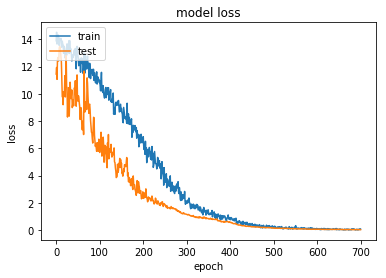

In [12]:
# Plot Loss Curve
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

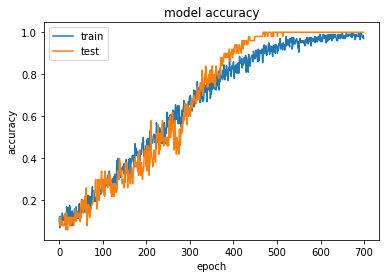

In [13]:
# Plot Accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

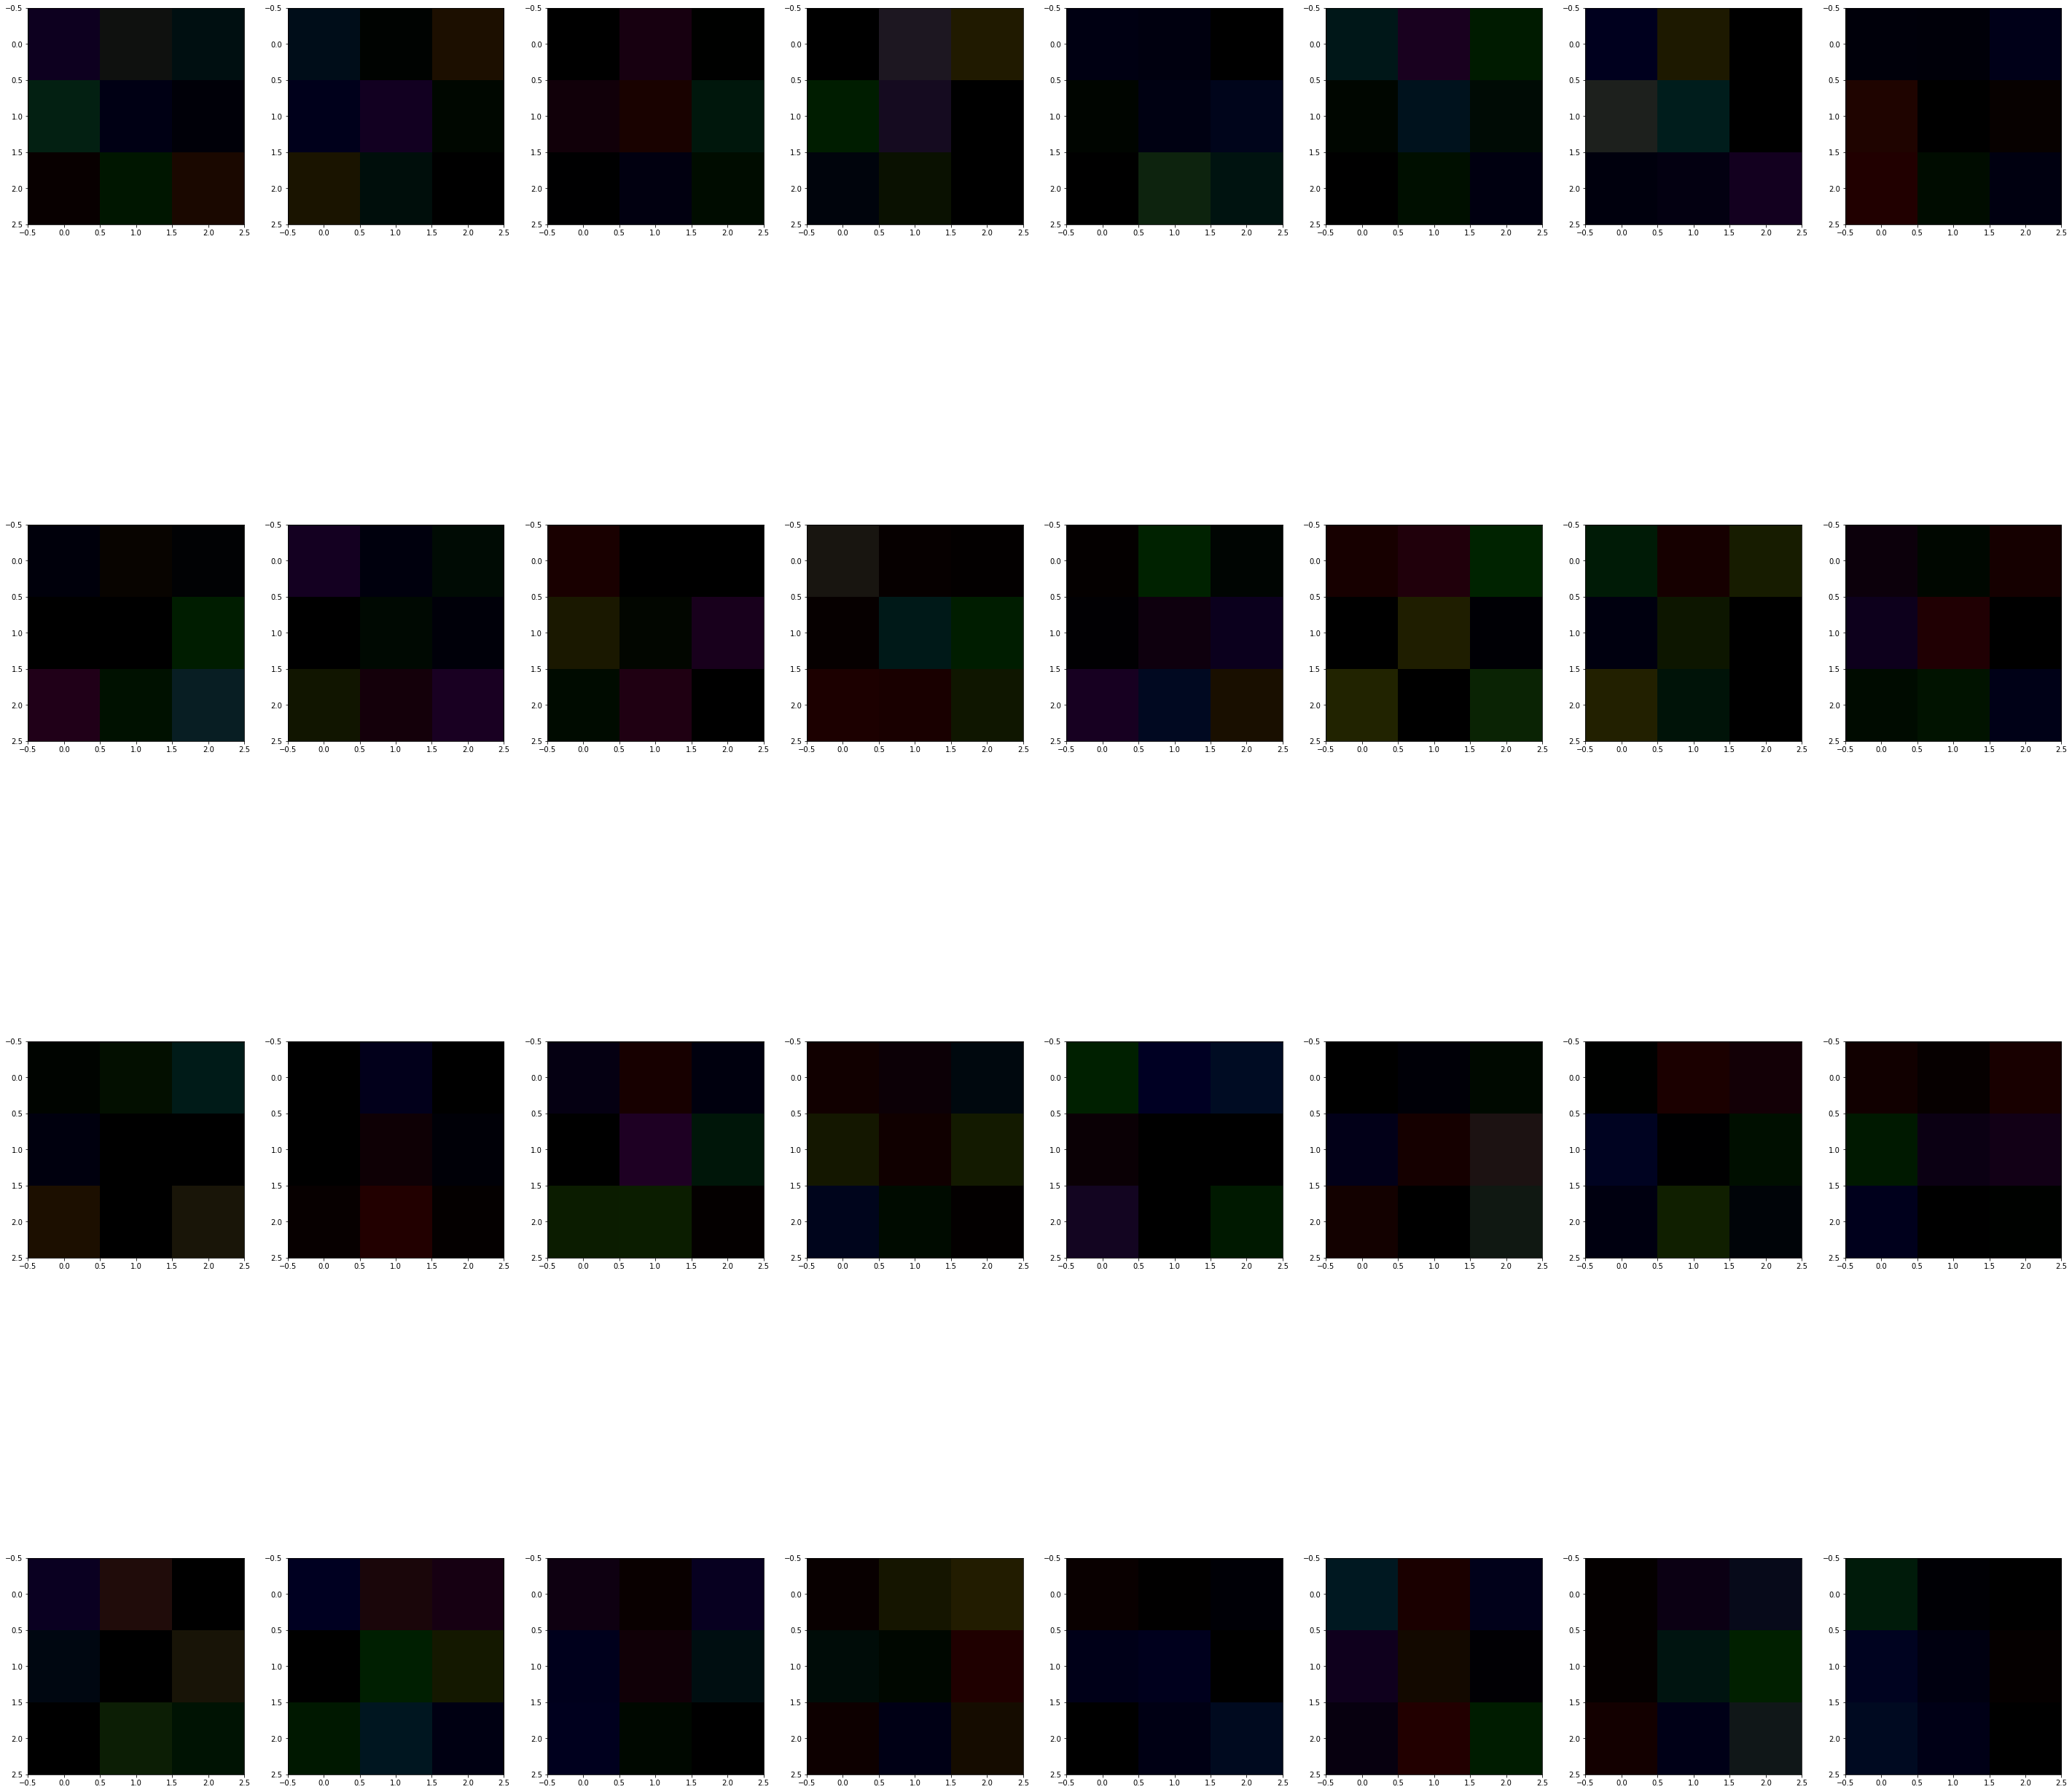

In [14]:
# filter visualization in the 1st-layer
top_layer = model.layers[0]
filter_number = 32
for i in range(filter_number):
    plt.figure(2,figsize = (10*5,10*5))
    plt.subplot(4,8,i+1)
    plt.imshow(top_layer.get_weights()[0][:, :, :, i].squeeze(), cmap='viridis')

(256, 256, 3)


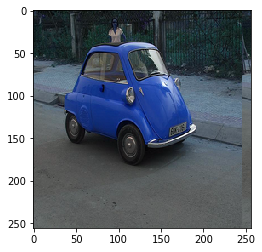

In [15]:
# visualization of all the activations in the network

# show a sample (origin)
image_sample = Input_vehicles[0:1][0]
print(image_sample.shape)
plt.imshow(image_sample)



In [16]:
# Extracts the outputs of the top 8 layers:

layer_outputs = [layer.output for layer in model.layers[:8]]
image_sample = Input_vehicles[0:1]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

activations = activation_model.predict(image_sample)
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 254, 254, 32)


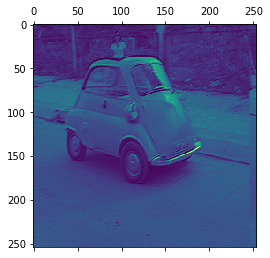

In [17]:
# visualizing the 1st channel
plt.matshow(first_layer_activation[0, :, :, 0], cmap='viridis')
plt.show()

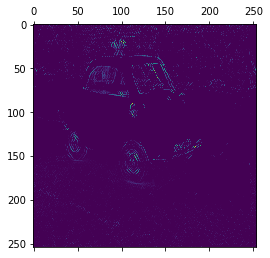

In [22]:
# visualizing the 14th channel
plt.matshow(first_layer_activation[0, :, :, 13], cmap='viridis')
plt.show()

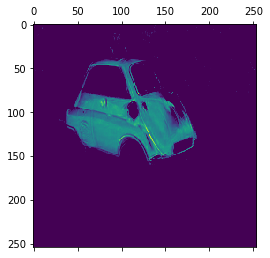

In [24]:
# visualizing the 27nd channel
plt.matshow(first_layer_activation[0, :, :, 26], cmap='viridis')
plt.show()

In [25]:
# names of the layers
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

/opt/conda/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in divide


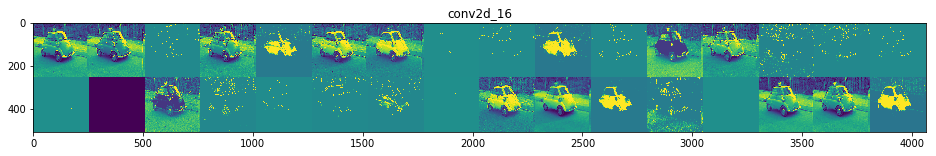

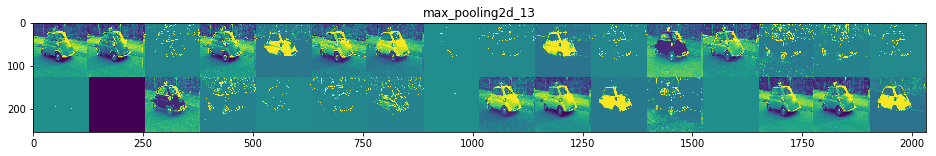

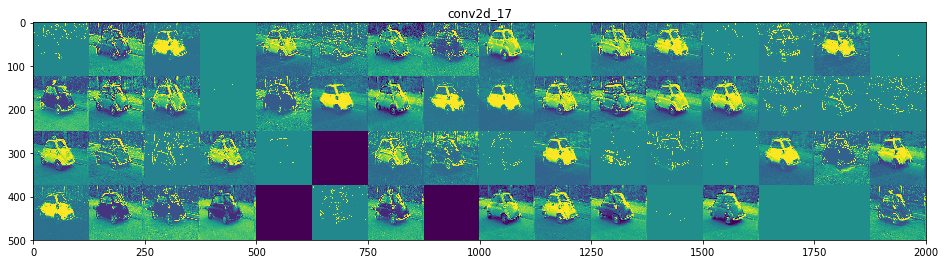

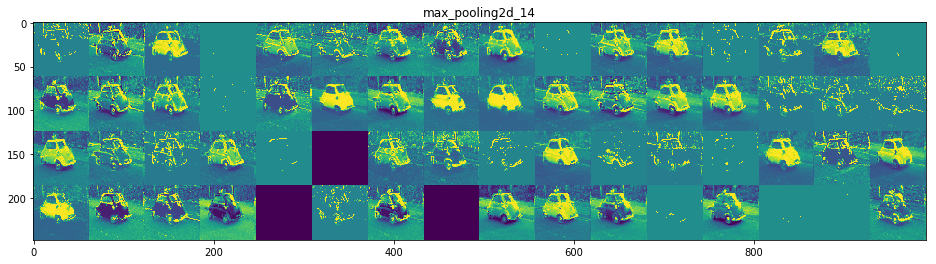

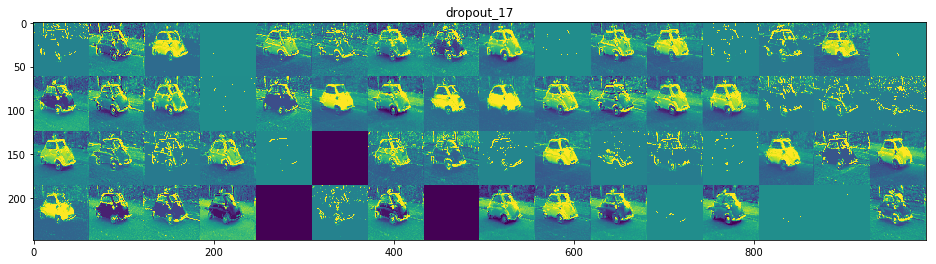

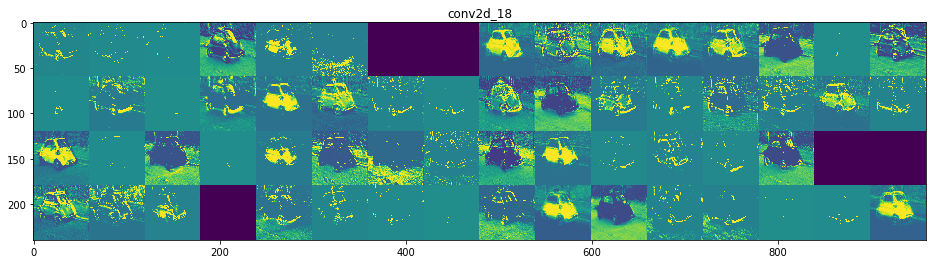

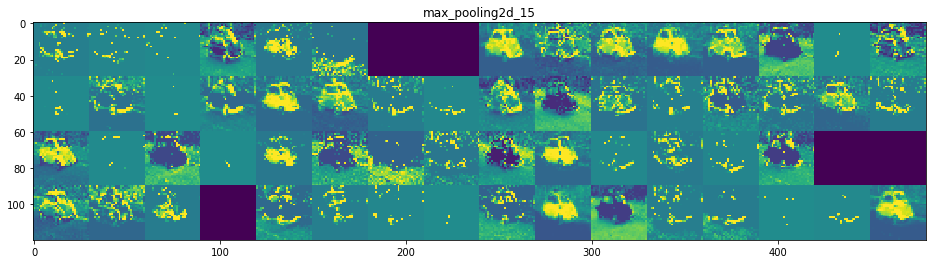

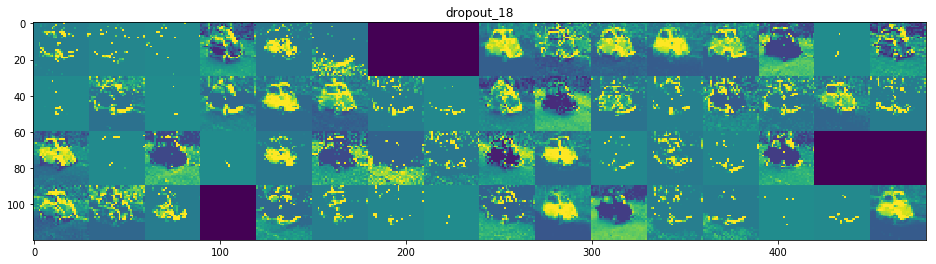

In [26]:
# Display feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()